In [ ]:
# default_exp

# Creating Ambiguous-MNIST for Dirty-MNIST
> Synthesizing an ambiguous version of MNIST step-by-step.

Please cite us:

```
@article{mukhoti2021deterministic,
  title={Deterministic Neural Networks with Appropriate Inductive Biases Capture Epistemic and Aleatoric Uncertainty},
  author={Mukhoti, Jishnu and Kirsch, Andreas and van Amersfoort, Joost and Torr, Philip HS and Gal, Yarin},
  journal={arXiv preprint arXiv:2102.11582},
  year={2021}
}
```

You can find the paper here: https://arxiv.org/abs/2102.11582.

In [ ]:
# hide
# all_slow
from nbdev.showdoc import *

%config Completer.use_jedi = False

## Overview

We train a VAE on the original MNIST dataset to be able to synthesize new MNIST digits. Then, we train an ensemble of LeNet models on MNIST that we can use to select ambiguous samples (low epistemic uncertainty, high aleatoric uncertainty) from the VAE.

To calibrate the VAE's output to match MNIST's unwhitened outputs as much as possible, we synthesize unambiguous digits using the VAE first and then adjust the outputs slightly.

To cover a wider range of entropies, we employ stratified sampling of ambiguous samples while rejecting samples with high epistemic uncertainty (info gain).

We try to different means of sampling from the VAE. The first one samples randomly from the latent space (unit Gaussian). The other method encodes existing MNIST samples into the latent space and then interpolates between them, using Barycentric coordinates. I.e. by randomly picking a convex interpolation.

### Software Engineering

To save progress and resources, the script caches most results locally using a helper function `restore_or_create`. We did not upload the cache here&mdash;you can generate it yourself if you wish so. We only upload to this website the final AMNIST samples.

## Prerequisites

In [ ]:
import os
from functools import wraps

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tqdm.auto import tqdm

In [ ]:
torch.manual_seed(1)
np.random.seed(1)

# Setup matplotlib to make it easier to copy outputs into Slack (seriously).
plt.rcParams["figure.facecolor"] = "white"

batch_size = 128

Load MNIST:

In [ ]:
mnist_mean, mnist_std = 0.1307, 0.3081

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mnist_mean,), (mnist_std,))])

mnist_train_dataset = datasets.MNIST(root="./mnist_data/", train=True, transform=transform, download=True)
mnist_test_dataset = datasets.MNIST(root="./mnist_data/", train=False, transform=transform, download=True)

mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train_dataset, batch_size=batch_size, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset, batch_size=batch_size, shuffle=False)

Two helper functions to normalize and unnormalize MNIST samples. MNIST samples are stored as grayscale bytes in a range 0..255, which is first converted to 0..1 floats by the MNIST dataset code in `torchvision`. We then normalize the values further to have zero mean and standard deviation 1, which helps with training.

In [ ]:
def unnormalize_mnist(x):
    return x * mnist_std + mnist_mean

In [ ]:
def normalize_mnist(x):
    return (x - mnist_mean) / mnist_std

Finally, we need a helper function to make it easy to backup and restore resources:

In [ ]:
def restore_or_create(file_or_path, recreate: bool = False, *, pickle_module=None, pickle_load_args={}):
    pickle_module_arg = dict(pickle_module=pickle_module) if pickle_module else {}

    def delegate(func):
        @wraps(func)
        def wrapper():
            if not recreate:
                try:
                    return torch.load(file_or_path, {**pickle_load_args, **pickle_module_arg})
                except FileNotFoundError:
                    pass
            result = func()
            torch.save(result, file_or_path, pickle_protocol=-1, **pickle_module_arg)
            return result

        return wrapper

    return delegate

## VAE Code

This code is from https://github.com/pytorch/examples/blob/master/vae/main.py.

Note, we train it on whitened MNIST, and have adapted the loss function for that.

In [ ]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)  # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)  # return z sample

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return (F.sigmoid(self.fc6(h)) - mnist_mean) / mnist_std

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [ ]:
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(
        unnormalize_mnist(recon_x),
        unnormalize_mnist(x).view(-1, 784),
        reduction="sum",
    )
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [ ]:
def train_vae_epoch(vae, optimizer, train_loader, epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()

        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print("====> Epoch: {} Average loss: {:.4f}".format(epoch, train_loss / len(train_loader.dataset)))

In [ ]:
def test_vae(vae, test_loader):
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)

            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()

    test_loss /= len(test_loader.dataset)
    print("====> Test set loss: {:.4f}".format(test_loss))

### Training the VAE on MNIST

In [ ]:
@restore_or_create("vae_ambiguous_mnist.model", recreate=False)
def train_vae():
    z_dim = 32
    # build model
    vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=z_dim)
    if torch.cuda.is_available():
        vae.cuda()

    optimizer = optim.Adam(vae.parameters())
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 50, 65], gamma=0.2)

    os.makedirs("./samples", exist_ok=True)
    for epoch in tqdm(range(1, 75)):
        train_vae_epoch(vae, optimizer, mnist_train_loader, epoch)
        test_vae(vae, mnist_test_loader)
        scheduler.step()
        with torch.no_grad():
            z = torch.randn(64, z_dim).cuda()
            # print (z.shape)
            sample = vae.decoder(z).cuda()
            save_image(
                unnormalize_mnist(sample.view(64, 1, 28, 28)),
                "./samples/sample_" + str(epoch) + ".png",
            )

    return vae


vae = train_vae()
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=32, bias=True)
  (fc32): Linear(in_features=256, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

### Visualizing VAE samples

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter
from torchvision.utils import make_grid


def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")

Before we calibrate the VAE properly, we use the following method to post process the samples which will help them match the histogram of MNIST better. 

The original LeNet-5 paper states (using inverted colors):
> The values of the input pixels are normalized
so that the background level (white) corresponds to a value
of -0.1 and the foreground (black) corresponds to 1.175.
This makes the mean input roughly zero and the variance
roughly one, which accelerates learning. 

In [ ]:
def post_process_vae_output(sample):
    unnormalized = unnormalize_mnist(sample)
    unnormalized = torch.clamp(1.275 * unnormalized - 0.1, 0, 1)
    return unnormalized

Sample images from the latent space and visualize their histogram:

In [ ]:
def pixel_histogram(samples, num_bins):
    train_histogram = np.histogram(samples.cpu().flatten().numpy(), bins=num_bins)
    print(train_histogram[0] / samples.numel(), train_histogram[1])
    plt.bar(train_histogram[1][:-1], train_histogram[0], align="edge", width=1 / num_bins)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=samples.numel()))
    plt.show()

/home/blackhc/anaconda3/envs/ddu_dirty_mnist/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


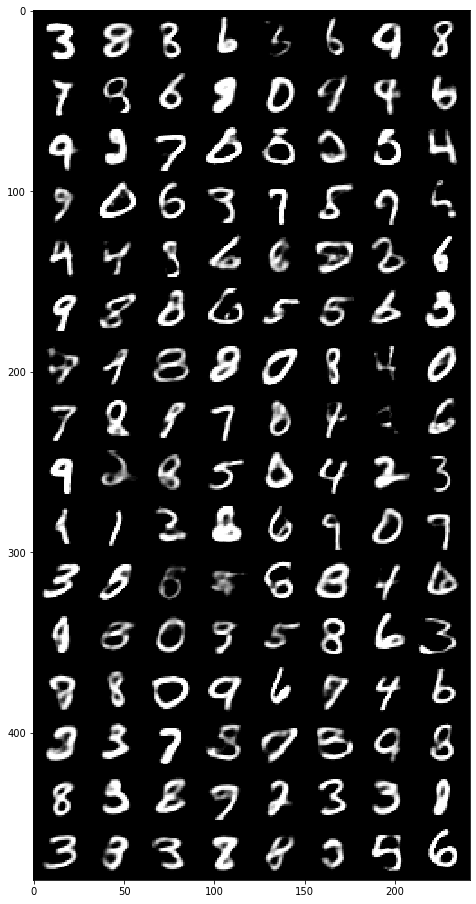

[0.79374601 0.01188815 0.00999482 0.00866948 0.00756338 0.00732422
 0.00703524 0.00686583 0.00658681 0.00646724 0.00656688 0.00713489
 0.00669643 0.0072146  0.00723453 0.00746373 0.00839047 0.00855987
 0.00998485 0.06461256] [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


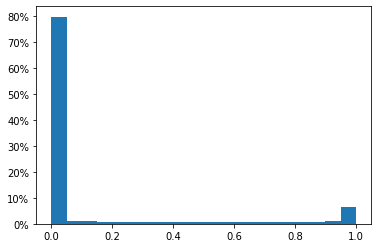

In [ ]:
plt.figure(figsize=(8, 16))

with torch.no_grad():
    z = torch.randn(128, 32).cuda()
    # print (z.shape)
    sample = vae.decoder(z).cuda()
    unnormalized = post_process_vae_output(sample.view(128, 1, 28, 28))
    show(make_grid(unnormalized, normalize=False, scale_each=False))
    plt.show()
    pixel_histogram(unnormalized, num_bins=20)

> Note: The samples above contain samples of varying ambiguity.

Compare to MNIST test samples:

tensor(0.) tensor(1.)


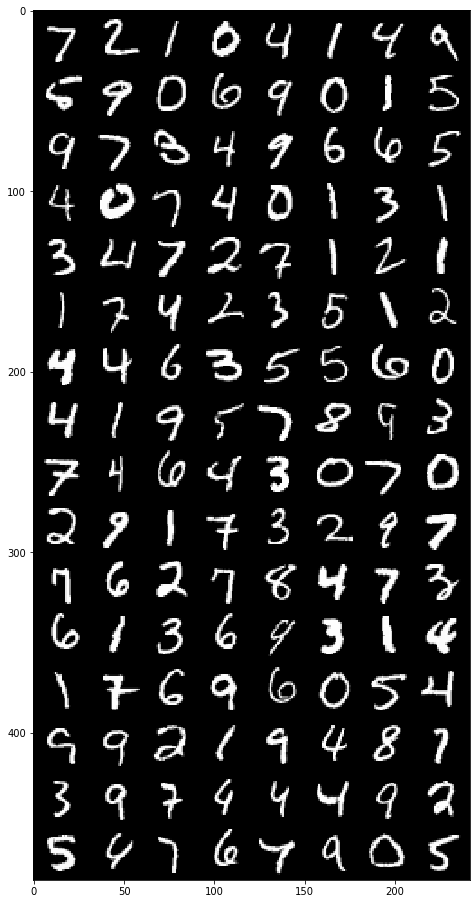

[0.83092514 0.00846022 0.00646724 0.00518176 0.0058793  0.00518176
 0.00520169 0.00443439 0.00427495 0.00443439 0.00578962 0.00445432
 0.00472337 0.00501236 0.00523158 0.0053412  0.00611846 0.00653699
 0.0085798  0.06777144] [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


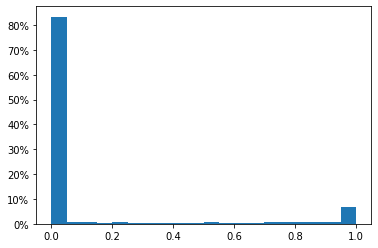

In [ ]:
plt.figure(figsize=(8, 16))
for data, _ in mnist_test_loader:
    unnormalized = unnormalize_mnist(data.view(batch_size, 1, 28, 28))
    print(unnormalized.min(), unnormalized.max())
    show(make_grid(unnormalized, normalize=False, scale_each=False))
    plt.show()
    plt.show()
    pixel_histogram(unnormalized, num_bins=20)
    break

The histograms are already quite similar. A visual test seems to validate this further.

## LeNet Ensemble for Classification

We want samples that are ambiguous but not out-of-distribution. Epistemic uncertainty should be low, but aleatoric uncertainty should be: **someone looking at the sample should recognize that is a digit, but should not be able to tell which one with certainty.**

We can measure epistemic uncertainty using the mutual information of an ensemble. When the mutual information is low, that is epistemic uncertainty is low, the predictive entropy will tell us the aleatoric uncertainty.

A slightly adapted version of LeNet-5 (https://ieeexplore.ieee.org/document/726791). We don't use padding, use max pooling and ReLUs.

In [ ]:
# Train a LeNet on MNIST
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [ ]:
def lenet_train(epoch, train_loader, optimizer, lenet):
    lenet.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.cuda()
        label = label.cuda()
        optimizer.zero_grad()

        out = lenet(data)
        loss = F.cross_entropy(out, label)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item() / len(data),
                )
            )
    print("====> Epoch: {} Average loss: {:.4f}".format(epoch, train_loss / len(train_loader.dataset)))


def lenet_test(test_loader, lenet):
    lenet.eval()
    test_loss = 0
    with torch.no_grad():
        for data, label in test_loader:
            data = data.cuda()
            label = label.cuda()
            out = lenet(data)

            # sum up batch loss
            test_loss += F.cross_entropy(out, label).item()

    test_loss /= len(test_loader.dataset)
    print("====> Test set loss: {:.4f}".format(test_loss))
    return test_loss

In [ ]:
lenets = []
num_ensemble_components = 5

for i in tqdm(range(num_ensemble_components)):

    @restore_or_create(f"lenet_model_{i}.model")
    def train_lenet_model():
        lenet = LeNet(num_classes=10).cuda()
        optimizer = optim.Adam(lenet.parameters())

        best_loss = None
        best_epoch = None
        for epoch in tqdm(
            range(1, 101 // num_ensemble_components)
        ):  # lenet seems to converge after about 10 epochs anyways..
            lenet_train(epoch, mnist_train_loader, optimizer, lenet)
            test_loss = lenet_test(mnist_test_loader, lenet)
            if not best_loss or best_loss > test_loss:
                torch.save(lenet.state_dict(), "./tmp_lenet_best.model")
                best_loss = test_loss
                best_epoch = epoch
                print("New best model", best_epoch, " with ", best_loss)

        print("Best epoch", best_epoch)

        lenet.load_state_dict(torch.load("./tmp_lenet_best.model"))
        return lenet

    lenets.append(train_lenet_model())

  0%|          | 0/5 [00:00<?, ?it/s]

## Calibrating the VAE

### Reconstructing MNIST's training set
Let's calibrate the output of the VAE to match real MNIST as much as possible. We want to improve over `post_process_vae_output` as much as possible. The simplest solution to this is to pass all MNIST training samples through the VAE and look at the histogram after they have been decoded.

In [ ]:
class_indices = [np.nonzero((mnist_train_dataset.targets == c).cpu().numpy())[0] for c in range(10)]

In [ ]:
def pred_entropy(
    pre_softmaxs,
):  # shape: [MC samples from pred / ensemble, num data, classes]
    softmaxs = F.softmax(pre_softmaxs, dim=-1)
    softmax = torch.mean(softmaxs, dim=0)
    logits = torch.log(softmax)
    nats = -logits * softmax
    nats[torch.isnan(nats)] = 0.0
    return nats.sum(dim=-1)


def avg_entropy(
    pre_softmaxs,
):  # shape: [MC samples from pred / ensemble, num data, classes]
    # NOTE: looking at average ent, not pred ent
    softmax = F.softmax(pre_softmaxs, dim=-1)
    logits = F.log_softmax(pre_softmaxs, dim=-1)
    nats = -logits * softmax
    nats[torch.isnan(nats)] = 0.0
    nats = nats.sum(dim=-1)  # sum over classes
    return nats.mean(dim=0)  # average over MC samples!

In [ ]:
@restore_or_create("decoded_mnist_train.pt", recreate=False)
@torch.no_grad()
def decode_mnist_train_samples():
    decoded_images = []
    decoded_labels = []

    correct_labels = 0
    total_labels = 0

    for data, labels in tqdm(
        zip(
            torch.split(normalize_mnist(mnist_train_dataset.data / 255.0), 1024),
            torch.split(torch.as_tensor(mnist_train_dataset.targets), 1024),
        )
    ):
        batch_mus = vae.encoder(data.cuda().view(-1, 784))[0]
        batch_images = vae.decoder(batch_mus).view(-1, 1, 28, 28)

        normalized_samples = normalize_mnist(post_process_vae_output(batch_images))
        lenet_pre_softmaxs = [lenet(normalized_samples.cuda()) for lenet in lenets]
        lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)

        batch_labels = F.softmax(lenet_pre_softmaxs, dim=-1).mean(dim=0).argmax(dim=-1)

        correct_labels += (batch_labels.cpu() == labels).sum().item()
        total_labels += len(labels)

        decoded_images.append(batch_images.cpu())
        decoded_labels.append(batch_labels.cpu())

    decoded_images = torch.cat(decoded_images).cpu()
    decoded_labels = torch.cat(decoded_labels).cpu()

    print(f"Acc: {100*correct_labels/total_labels}")
    return decoded_images, decoded_labels


(
    decoded_mnist_train_images,
    decoded_mnist_train_labels,
) = decode_mnist_train_samples()

[0.81766473 0.00818261 0.00677455 0.00538276 0.00559016 0.00534005
 0.00515952 0.00415232 0.00496624 0.00452874 0.00600338 0.0046942
 0.00468999 0.00529315 0.00565223 0.00537504 0.00601399 0.00699324
 0.00853648 0.07900661] [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


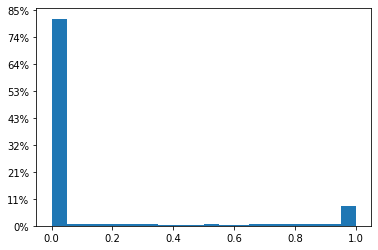

[0.80878151 0.00908006 0.00745744 0.00646762 0.00582778 0.00541203
 0.00514373 0.00494284 0.00484881 0.0048574  0.00488195 0.00502591
 0.00521507 0.0054771  0.00585381 0.00635389 0.00703382 0.00795721
 0.00914539 0.08023663] [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


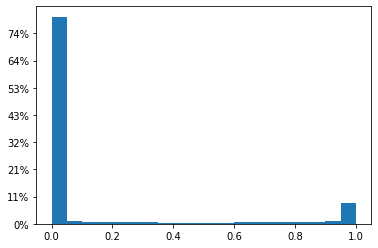

In [ ]:
num_histogram_bins = 20
pixel_histogram(mnist_train_dataset.data / 255.0, num_histogram_bins)
pixel_histogram(post_process_vae_output(decoded_mnist_train_images), num_bins=num_histogram_bins)

We see two peaks: 82% of the pixels are close to 0 and 7.9% are close to 1.

The histograms already look like quite similar. Can we do better though?

We will compute and adjust the unnormalized samples to match the unnormalized MNIST samples as much as possible, which yields `adjusted_post_process_vae_output`. The adjusted histogram mostly matches MNIST better now. This "optimization" was done using graduate student descent while treating the scale and shift in `adjusted_post_process_vae_output` as hyperparameters:

In [ ]:
vae_mnist_mean = torch.mean(decoded_mnist_train_images)
vae_mnist_std = torch.std(decoded_mnist_train_images)
print(vae_mnist_mean, vae_mnist_std)

vae_mnist_min, vae_mnist_max = (
    decoded_mnist_train_images.min(),
    decoded_mnist_train_images.max(),
)
print(vae_mnist_min, vae_mnist_max)

tensor(-5.7765e-06) tensor(0.9357)
tensor(-0.4242) tensor(2.8213)


For comparison, let's verify that our MNIST normalization constants are sensible:

In [ ]:
torch.mean(mnist_train_dataset.data / 255.0), torch.std(mnist_train_dataset.data / 255.0)

(tensor(0.1307), tensor(0.3081))

In [ ]:
mnist_mean, mnist_std

(0.1307, 0.3081)

Anyhow, here is the adjusted post-processing function:

In [ ]:
def adjusted_post_process_vae_output(sample):
    # Instead of using unnormalize_mnist directly, we first normalize the samples using the real mean and std dev.
    normalized_amnist = (sample - vae_mnist_mean) / vae_mnist_std
    unnormalized_mnist = unnormalize_mnist(normalized_amnist)
    unnormalized_mnist = torch.clamp(1.20 * unnormalized_mnist - 0.15, 0, 1)
    return unnormalized_mnist

[0.81321301 0.00445172 0.00454622 0.00363639 0.0034013  0.00337326
 0.00273287 0.00264989 0.0031994  0.00239075 0.00315825 0.0021818
 0.00218325 0.00297628 0.00210927 0.00204305 0.0025611  0.00240514
 0.00245193 0.00207681 0.00344913 0.00255425 0.00242466 0.00226954
 0.00251603 0.00217396 0.00308497 0.00220818 0.0022665  0.00338574
 0.00262659 0.00274845 0.00298314 0.00303085 0.00348125 0.00351199
 0.00394821 0.00458827 0.00460944 0.07439717] [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ]


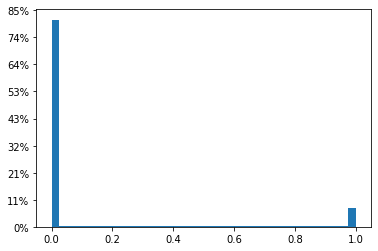

[0.81529634 0.00408503 0.00374069 0.00344713 0.00324371 0.00306027
 0.00290755 0.00280285 0.00269681 0.00262083 0.0025581  0.00252349
 0.00245804 0.00243395 0.00240708 0.00240731 0.0024156  0.00241301
 0.00242353 0.00244477 0.00248323 0.00252823 0.00257993 0.00264058
 0.00269915 0.00278854 0.00288301 0.00299082 0.00311031 0.00326952
 0.00343121 0.00364415 0.00387192 0.00414356 0.00442989 0.00480544
 0.0052432  0.00576556 0.00644454 0.06186112] [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ]


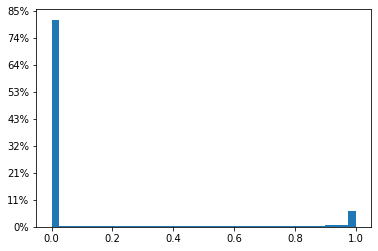

[0.80324728 0.00553423 0.0048037  0.00427636 0.00387283 0.00358461
 0.00332192 0.00314571 0.0029743  0.00285349 0.00275085 0.00266118
 0.00258895 0.00255478 0.00248863 0.00245421 0.00242808 0.00242073
 0.00242838 0.00242902 0.00242343 0.00245852 0.00248718 0.00253873
 0.002573   0.00264207 0.00269779 0.00277932 0.00287253 0.00298127
 0.00310912 0.00324477 0.00341327 0.00362056 0.00384537 0.00411184
 0.00439464 0.00475074 0.00519116 0.07504547] [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ]


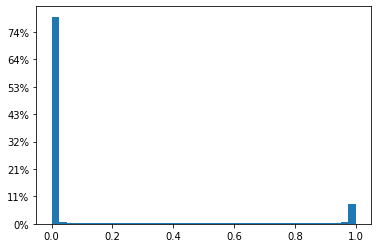

In [ ]:
num_histogram_bins = 20 * 2
pixel_histogram(mnist_train_dataset.data / 255.0, num_histogram_bins)
pixel_histogram(adjusted_post_process_vae_output(decoded_mnist_train_images), num_bins=num_histogram_bins)
pixel_histogram(post_process_vae_output(decoded_mnist_train_images), num_bins=num_histogram_bins)

### Wasserstein Distance

In [ ]:
from scipy.stats import wasserstein_distance

In [ ]:
def compare_distributions(pixels_a, pixels_b):
    return wasserstein_distance(pixels_a.flatten().numpy(), pixels_b.flatten().numpy())

In [ ]:
print(
    "MNIST vs reconstruction:",
    compare_distributions(mnist_train_dataset.data / 255.0, post_process_vae_output(decoded_mnist_train_images)),
)
print(
    "MNIST vs adjusted reconstruction:",
    compare_distributions(
        mnist_train_dataset.data / 255.0, adjusted_post_process_vae_output(decoded_mnist_train_images)
    ),
)

MNIST vs reconstruction: 0.0058388380341273145
MNIST vs adjusted reconstruction: 0.002503224875531966


`adjusted_post_process_vae_output` improves the histgram more than `post_process_vae_output`, which is what we wanted.

### Visualizing a few samples

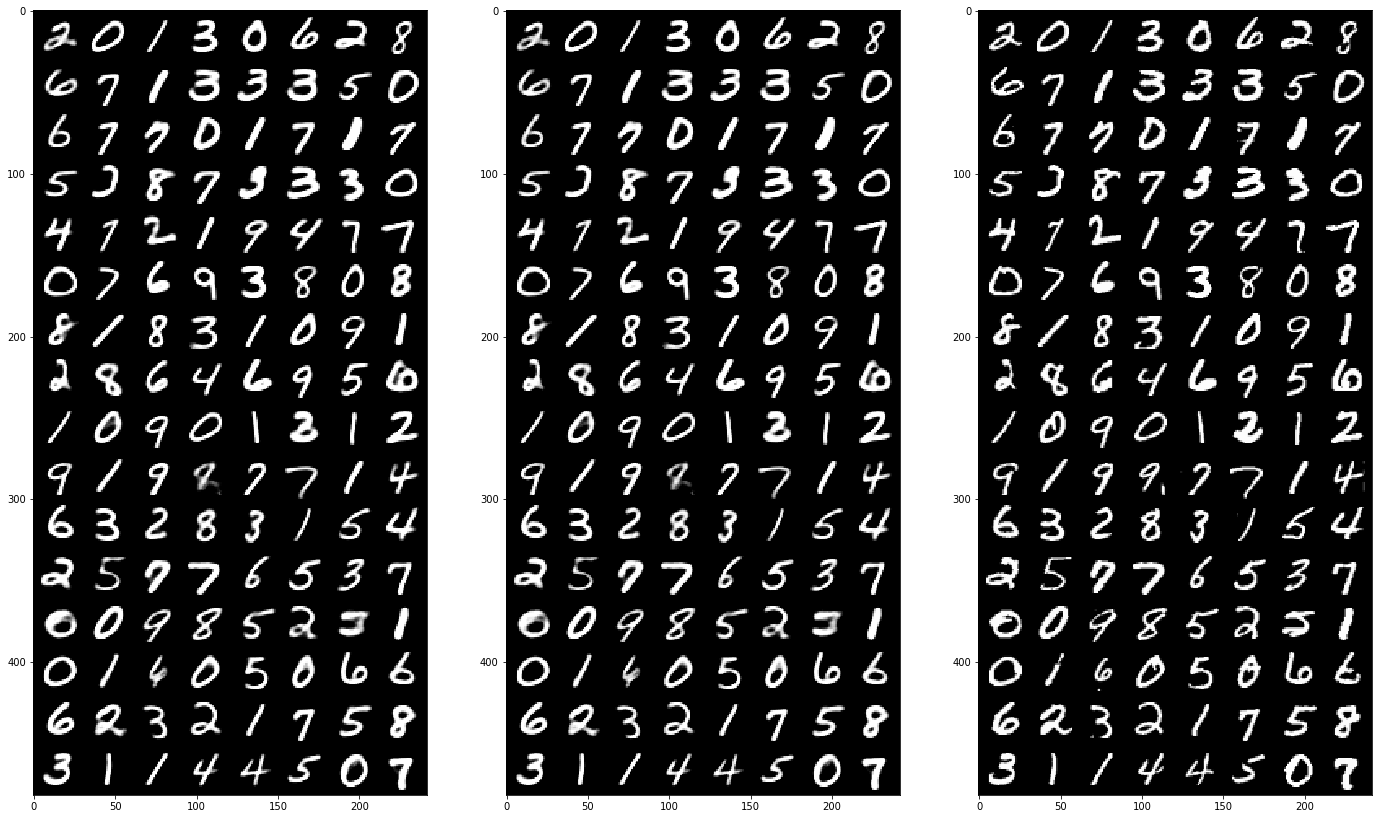

In [ ]:
plt.figure(figsize=(24, 16))
plt.subplot(1, 3, 1)

sample = decoded_mnist_train_images[5 :: len(decoded_mnist_train_images) // 128][:128]
unnormalized = post_process_vae_output(sample.view(128, 1, 28, 28))
show(make_grid(unnormalized, normalize=False, scale_each=False))

plt.subplot(1, 3, 2)
sample = decoded_mnist_train_images[5 :: len(decoded_mnist_train_images) // 128][:128]
unnormalized = adjusted_post_process_vae_output(sample.view(128, 1, 28, 28))
show(make_grid(unnormalized, normalize=False, scale_each=False))

plt.subplot(1, 3, 3)
sample = mnist_train_dataset.data[5 :: len(mnist_train_dataset.data) // 128][:128] / 255.0
unnormalized = sample.view(128, 1, 28, 28)
show(make_grid(unnormalized, normalize=False, scale_each=False))
plt.show()

## Creating Ambiguous VAE Samples

We try to different methods: 
a) we sample from the latent space. Because we have a VAE, the latents are optimized to conform to a Gaussian distribution.
b) we sample from convex combinations of latents from real MNIST training samples.

### Sampling from the Latent Space

In [ ]:
@restore_or_create("stratified_ambiguous_samples.pt", recreate=False)
@torch.no_grad()
def create_stratified_ambiguous_samples():
    mi_threshold = 0.05
    bin_edges = [0, 0.05, 0.5, 1.0, 10.0]
    target_counts = [60000, 30000, 20000, 10000]
    num_bins = len(bin_edges) - 1
    bucket_counts = [0] * num_bins
    buckets = [[] for _ in range(num_bins)]

    assert len(target_counts) == len(bucket_counts) == len(buckets) == num_bins

    batch_size = 16384

    total_target_count = sum(target_counts)

    sample_progress = tqdm(range(total_target_count))
    while any(count < target for count, target in zip(bucket_counts, target_counts)):
        z = torch.randn(batch_size, 32).cuda()
        decoded_lerps = vae.decoder(z).view(batch_size, 1, 28, 28)

        normalized_samples = normalize_mnist(adjusted_post_process_vae_output(decoded_lerps))
        lenet_pre_softmaxs = [lenet(normalized_samples.cuda()) for lenet in lenets]
        lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)
        batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
        batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)
        batch_mi = batch_pred_entropies - batch_avg_entropies

        id_samples = batch_mi <= mi_threshold

        for bucket_index, (count, target, bucket, lower, upper) in enumerate(
            zip(
                bucket_counts,
                target_counts,
                buckets,
                bin_edges[:-1],
                bin_edges[1:],
            )
        ):
            bucket_samples = id_samples & (lower <= batch_pred_entropies) & (batch_pred_entropies < upper)
            num_new_samples = bucket_samples.sum().item()

            if num_new_samples == 0 or count >= target:
                continue

            bucket.append(decoded_lerps[bucket_samples])
            bucket_counts[bucket_index] += num_new_samples
            sample_progress.update(num_new_samples)

    sample_progress.close()

    buckets = [torch.cat(bucket).cpu() for bucket in buckets if bucket]
    buckets = torch.cat(buckets)
    return buckets


stratified_ambiguous_samples_random_latent = create_stratified_ambiguous_samples().cpu()

### Sampling Convex Combinations of MNIST Training Samples

In [ ]:
@restore_or_create("stratified_ambiguous_samples_convex_mixture.pt", recreate=False)
@torch.no_grad()
def create_stratified_ambiguous_mixture_samples():
    mi_threshold = 0.05
    bin_edges = [0, 0.05, 0.5, 1.0, 1.6]
    target_counts = [60000, 60000, 40000, 20000]
    num_bins = len(bin_edges) - 1
    bucket_counts = [0] * num_bins
    buckets = [[] for _ in range(num_bins)]

    assert len(target_counts) == len(bucket_counts) == len(buckets) == num_bins

    total_target_count = sum(target_counts)

    num_samples_per_clique = 64

    num_label_range = list(range(2, 5))

    batch_size = 65536 // num_samples_per_clique

    sample_progress = tqdm(total=total_target_count)
    while any(count < target for count, target in zip(bucket_counts, target_counts)):
        sample_progress.total = sum(max(count, target) for count, target in zip(bucket_counts, target_counts))

        for num_labels in num_label_range:
            num_new_samples = 0

            batch_labels = []
            batch_data = []
            for j in range(batch_size):
                label = np.random.choice(10, num_labels, replace=False)
                batch_indices = [np.random.choice(len(class_indices[c]), 1)[0] for c in label]
                data = torch.stack([mnist_train_dataset[i][0] for i in batch_indices]).cuda()
                label = torch.tensor(label).cuda()
                batch_labels.append(label)
                batch_data.append(data)

            batch_data = torch.stack(batch_data)
            batch_labels = torch.stack(batch_labels)

            mu, logvar = vae.encoder(batch_data.view(-1, 784))

            mix_weights = torch.rand(batch_size * num_samples_per_clique, num_labels + 1).cuda()
            mix_weights[:, 0] = 0
            mix_weights[:, -1] = 1
            mix_weights = torch.sort(mix_weights, dim=-1)[0]
            mix_weights = mix_weights[:, 1:] - mix_weights[:, :-1]
            mixed_encodings = mix_weights.view(batch_size, num_samples_per_clique, num_labels) @ mu.view(
                batch_size, num_labels, -1
            )
            decoded_lerps = vae.decoder(mixed_encodings).view(batch_size * num_samples_per_clique, 1, 28, 28)

            normalized_samples = normalize_mnist(adjusted_post_process_vae_output(decoded_lerps))
            lenet_pre_softmaxs = [lenet(normalized_samples.cuda()) for lenet in lenets]
            lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)
            batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
            batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)
            batch_mi = batch_pred_entropies - batch_avg_entropies

            id_samples = batch_mi <= mi_threshold

            for bucket_index, (count, target, bucket, lower, upper,) in enumerate(
                zip(
                    bucket_counts,
                    target_counts,
                    buckets,
                    bin_edges[:-1],
                    bin_edges[1:],
                )
            ):
                bucket_samples = id_samples & (lower <= batch_pred_entropies) & (batch_pred_entropies < upper)
                num_new_samples = bucket_samples.sum().item()

                if num_new_samples == 0 or count >= target:
                    continue

                bucket.append(decoded_lerps[bucket_samples].cpu())
                bucket_counts[bucket_index] += num_new_samples
                sample_progress.update(num_new_samples)

    sample_progress.close()

    buckets = [torch.cat(bucket).cpu() for bucket in buckets if bucket]
    buckets = torch.cat(buckets).cpu()
    return buckets


stratified_ambiguous_samples_convex_mixture = create_stratified_ambiguous_mixture_samples().cpu()

In [ ]:
@restore_or_create("ambiguous_samples_convex_mixture.pt", recreate=True)
@torch.no_grad()
def create_ambiguous_mixture_samples():
    mi_threshold = 0.05
    bin_edges = [0.05, 3]
    target_counts = [2 ** 20 * 4]
    num_bins = len(bin_edges) - 1
    bucket_counts = [0] * num_bins
    buckets = [[] for _ in range(num_bins)]

    assert len(target_counts) == len(bucket_counts) == len(buckets) == num_bins

    total_target_count = sum(target_counts)

    num_samples_per_clique = 64

    num_label_range = list(range(2, 5))

    batch_size = 65536 // num_samples_per_clique

    label_batch_size = 32

    sample_progress = tqdm(total=total_target_count)
    while any(count < target for count, target in zip(bucket_counts, target_counts)):
        sample_progress.total = sum(max(count, target) for count, target in zip(bucket_counts, target_counts))

        for num_labels in num_label_range:
            num_new_samples = 0

            batch_labels = []
            batch_data = []
            for j in range(batch_size // label_batch_size):
                label = np.random.choice(10, num_labels, replace=False)
                batch_indices = [np.random.choice(len(class_indices[c]), label_batch_size) for c in label]
                data = torch.stack(
                    [normalize_mnist(mnist_train_dataset.data[i] / 255.0) for i in batch_indices], dim=1
                ).cuda()
                label = torch.tensor(np.repeat(label, label_batch_size)).cuda()
                batch_labels.append(label)
                batch_data.append(data)

            batch_data = torch.stack(batch_data)
            batch_labels = torch.stack(batch_labels)

            mu, logvar = vae.encoder(batch_data.view(-1, 784))

            mix_weights = torch.rand(batch_size * num_samples_per_clique, num_labels + 1).cuda()
            mix_weights[:, 0] = 0
            mix_weights[:, -1] = 1
            mix_weights = torch.sort(mix_weights, dim=-1)[0]
            mix_weights = mix_weights[:, 1:] - mix_weights[:, :-1]
            mixed_encodings = mix_weights.view(batch_size, num_samples_per_clique, num_labels) @ mu.view(
                batch_size, num_labels, -1
            )
            decoded_lerps = vae.decoder(mixed_encodings).view(batch_size * num_samples_per_clique, 1, 28, 28)

            normalized_samples = normalize_mnist(adjusted_post_process_vae_output(decoded_lerps))
            lenet_pre_softmaxs = [lenet(normalized_samples.cuda()) for lenet in lenets]
            lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)
            batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
            batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)
            batch_mi = batch_pred_entropies - batch_avg_entropies

            id_samples = batch_mi <= mi_threshold

            for bucket_index, (count, target, bucket, lower, upper,) in enumerate(
                zip(
                    bucket_counts,
                    target_counts,
                    buckets,
                    bin_edges[:-1],
                    bin_edges[1:],
                )
            ):
                bucket_samples = id_samples & (lower <= batch_pred_entropies) & (batch_pred_entropies < upper)
                num_new_samples = bucket_samples.sum().item()

                if num_new_samples == 0 or count >= target:
                    continue

                bucket.append(decoded_lerps[bucket_samples].cpu())
                bucket_counts[bucket_index] += num_new_samples
                sample_progress.update(num_new_samples)

    sample_progress.close()

    buckets = [torch.cat(bucket).cpu() for bucket in buckets if bucket]
    buckets = torch.cat(buckets).cpu()
    return buckets


ambiguous_samples_convex_mixture = create_ambiguous_mixture_samples().cpu()

  0%|          | 0/4194304 [00:00<?, ?it/s]

/home/blackhc/anaconda3/envs/ddu_dirty_mnist/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


### Comparison of the different sampling methods

We compute various statistics to examine the samples we have generated further.

In [ ]:
from dataclasses import dataclass


@dataclass
class SampleEvaluation:
    pred_entropies: torch.Tensor
    mutual_infos: torch.Tensor
    softmax_logits: torch.Tensor
    softmax_predictions: torch.Tensor
    predictions: torch.Tensor
    single_labels: torch.Tensor

In [ ]:
@torch.no_grad()
def evaluate_samples(samples):
    pred_entropies = []
    avg_entropies = []
    softmax_logits = []
    softmax_predictions = []
    predictions = []
    predicted_labels = []

    for decoded_image_batch in tqdm(torch.split(samples, 32768)):
        normalized_sample = normalize_mnist(adjusted_post_process_vae_output(decoded_image_batch.cuda()))
        lenet_pre_softmaxs = [lenet(normalized_sample) for lenet in lenets]
        lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)

        batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
        batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)

        pred_entropies.append(batch_pred_entropies.cpu())
        avg_entropies.append(batch_avg_entropies.cpu())

        lenet_pre_softmaxs = torch.transpose(lenet_pre_softmaxs, 0, 1)  # swap MC samples with batch dims
        softmax_logits.append(lenet_pre_softmaxs.cpu())

        batch_sm_pred = F.softmax(lenet_pre_softmaxs, dim=-1)
        softmax_predictions.append(batch_sm_pred.cpu())

        batch_pred = batch_sm_pred.mean(dim=1)
        predictions.append(batch_pred.cpu())

        batch_pred_labels = batch_pred.argmax(-1)
        predicted_labels.append(batch_pred_labels.cpu())

    pred_entropies = torch.cat(pred_entropies)
    avg_entropies = torch.cat(avg_entropies)
    softmax_logits = torch.cat(softmax_logits)
    softmax_predictions = torch.cat(softmax_predictions)
    predictions = torch.cat(predictions)
    predicted_labels = torch.cat(predicted_labels)

    return SampleEvaluation(
        pred_entropies,
        pred_entropies - avg_entropies,
        softmax_logits,
        softmax_predictions,
        predictions,
        predicted_labels,
    )


stratified_ambiguous_samples_random_latent_evaluation = restore_or_create(
    "stratified_ambiguous_samples_random_latent_evaluation.pt", recreate=False
)(lambda: evaluate_samples(stratified_ambiguous_samples_random_latent))()

stratified_ambiguous_samples_convex_mixture_evaluation = restore_or_create(
    "stratified_ambiguous_samples_convex_mixture_evaluation.pt", recreate=False
)(lambda: evaluate_samples(stratified_ambiguous_samples_convex_mixture))()

ambiguous_samples_convex_mixture_evaluation = restore_or_create(
    "ambiguous_samples_convex_mixture_evaluation.pt", recreate=True
)(lambda: evaluate_samples(ambiguous_samples_convex_mixture))()

  0%|          | 0/129 [00:00<?, ?it/s]

### Predictive Entropy Histogram

> Note: we have removed samples with MI > 0.05)

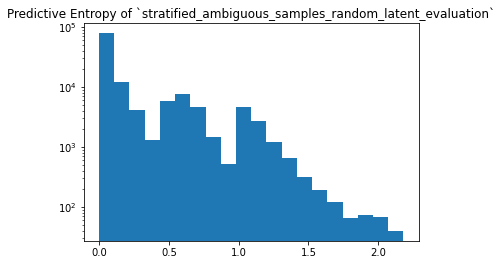

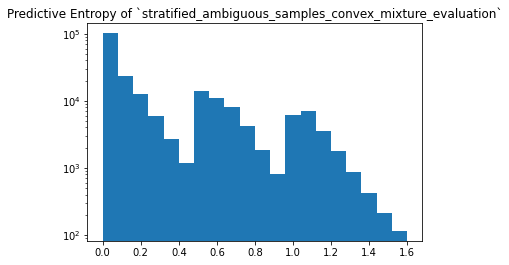

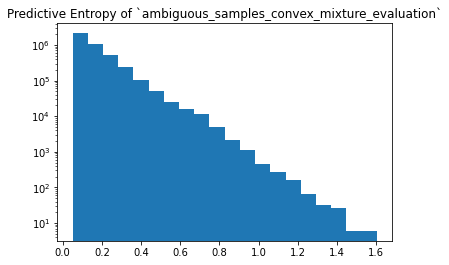

In [ ]:
plt.yscale("log")
plt.hist(stratified_ambiguous_samples_random_latent_evaluation.pred_entropies.numpy(), bins=20)
plt.title("Predictive Entropy of `stratified_ambiguous_samples_random_latent_evaluation`")
plt.show()

plt.yscale("log")
plt.hist(stratified_ambiguous_samples_convex_mixture_evaluation.pred_entropies.numpy(), bins=20)
plt.title("Predictive Entropy of `stratified_ambiguous_samples_convex_mixture_evaluation`")
plt.show()

plt.yscale("log")
plt.hist(ambiguous_samples_convex_mixture_evaluation.pred_entropies.numpy(), bins=20)
plt.title("Predictive Entropy of `ambiguous_samples_convex_mixture_evaluation`")
plt.show()

#### Example Samples

[[5], [5], [2], [4]]
[[5], [4], [6], [4]]
[[2], [9], [2], [7]]
[[3], [1], [9], [4]]
[[2], [6], [4], [2]]
[[7], [1], [1], [6]]
[[1], [9], [3], [0]]
[[7], [8], [7], [5]]
[[8], [8, 2], [1], [9, 3]]
[[9, 7], [8, 5], [6, 5], [8, 5]]
[[1, 7], [1, 7], [4, 9], [6]]
[[2, 0], [1, 7], [1, 7], [9, 7]]
[[7, 2], [7, 1], [4, 9], [7, 3]]
[[0, 5], [1, 7], [5, 1], [1, 3]]
[[0, 6], [1, 7], [9, 7], [7, 1]]


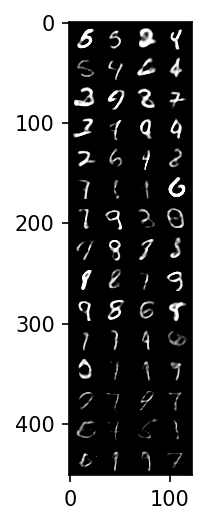

[[8], [6], [6], [8]]
[[9], [3], [6], [4]]
[[2], [3], [1], [1]]
[[9], [4], [9], [4]]
[[2], [3], [9], [5]]
[[5], [9], [2], [5]]
[[1], [9], [9], [8]]
[[9], [5, 6], [6], [2]]
[[4, 9], [6, 5], [8], [9, 0]]
[[1, 7], [8, 5], [8], [8, 2]]
[[1, 3], [8, 5], [9, 8], [7, 2]]
[[1, 8], [3, 9], [8, 9], [9, 7]]
[[3, 2], [1, 7], [1, 3], [1, 7]]
[[7, 3], [9, 8], [1, 8], [2, 7]]
[[7, 9], [8, 9], [7, 9], [3, 9, 8]]


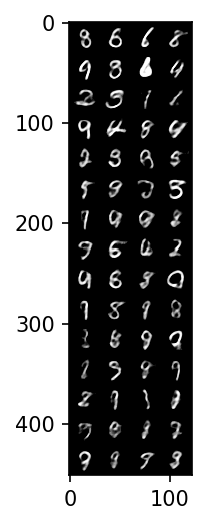

[[9], [3], [5], [2]]
[[4], [8], [9], [4]]
[[9], [5], [9], [3]]
[[4], [8], [3], [8]]
[[5], [3], [9], [1]]
[[6], [9], [1], [2]]
[[7], [2], [4, 9], [7]]
[[0], [7], [7], [5, 8]]
[[8, 2], [9], [5, 3], [8]]
[[0], [3, 5], [9], [5, 6]]
[[2, 0], [7, 9], [5, 3], [1]]
[[9, 8], [9, 8], [5, 6], [8, 3]]
[[2, 8], [9, 7], [8, 9], [8, 1]]
[[1, 3], [9, 1], [8, 1], [6, 5]]
[[6, 5], [7, 9], [1, 7], [6, 8]]


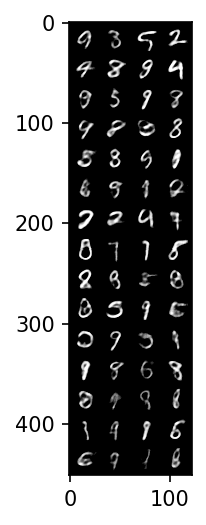

In [ ]:
def show_stratified_samples(
    samples, pred_entropies, num_pe_bins, num_bin_samples, bin_range=None, predictions=None, one_per_class=False
):
    stratified_samples = []
    edges = np.histogram_bin_edges(pred_entropies, bins=num_pe_bins, range=bin_range)
    for lower, upper in zip(edges[:-1], edges[1:]):
        bucket_mask = (pred_entropies >= lower) & (pred_entropies < upper)
        bucket_samples = samples[bucket_mask]
        if one_per_class:
            assert num_bin_samples == 10
            assert predictions is not None
            bucket_predictions = predictions[bucket_mask]
            bucket_labels = predictions[bucket_mask].argmax(dim=-1)
            sample_indices = np.concatenate(
                [np.random.choice(torch.nonzero(bucket_labels == c, as_tuple=False)[:, 0], size=1) for c in range(10)]
            )
        else:
            sample_indices = np.random.choice(len(bucket_samples), size=num_bin_samples, replace=False)
        row_samples = bucket_samples[sample_indices]
        stratified_samples.append(row_samples)
        if predictions is not None:
            sorted_probs, original_indices = torch.sort(
                predictions[bucket_mask][sample_indices], dim=-1, descending=True
            )
            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
            row_labels = []
            for sample_classes, cumulative_prob in zip(original_indices, cumulative_probs):
                majority_labels = []
                for c, cs in zip(sample_classes, cumulative_prob):
                    majority_labels += [c.item()]
                    if cs > 0.8:
                        break
                row_labels += [majority_labels]
            print(row_labels)

    stratified_samples = torch.cat(stratified_samples)
    plt.figure(figsize=(num_pe_bins, num_bin_samples), dpi=150)
    show(
        make_grid(
            adjusted_post_process_vae_output(stratified_samples.view(-1, 1, 28, 28)),
            normalize=False,
            nrow=num_bin_samples,
        )
    )
    plt.show()


show_stratified_samples(
    stratified_ambiguous_samples_random_latent,
    stratified_ambiguous_samples_random_latent_evaluation.pred_entropies,
    15,
    4,
    bin_range=[0.05, 1.1],
    predictions=stratified_ambiguous_samples_random_latent_evaluation.predictions,
)
show_stratified_samples(
    stratified_ambiguous_samples_convex_mixture,
    stratified_ambiguous_samples_convex_mixture_evaluation.pred_entropies,
    15,
    4,
    bin_range=[0.05, 1.1],
    predictions=stratified_ambiguous_samples_convex_mixture_evaluation.predictions,
)
show_stratified_samples(
    ambiguous_samples_convex_mixture,
    ambiguous_samples_convex_mixture_evaluation.pred_entropies,
    15,
    4,
    bin_range=[0.05, 1.1],
    predictions=ambiguous_samples_convex_mixture_evaluation.predictions,
)

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0, 2], [1], [2, 8], [3], [4, 9], [5], [6], [7], [8], [9]]
[[0, 2], [1], [2, 8], [3, 8], [4, 9], [5, 3], [6], [7, 2], [8, 9], [9]]
[[0, 9], [1, 7], [2, 7], [3, 8], [4, 7], [5, 3], [6, 5], [7, 9], [8, 3], [9, 4]]
[[0, 2], [1, 7], [2, 7], [3, 2], [4, 9], [5, 8], [6, 5], [7, 1], [8, 5], [9, 7]]
[[0, 8], [1, 7], [2, 1, 7], [3, 7], [4, 9], [5, 9, 7], [6, 8], [7, 9], [8, 3, 9], [9, 3]]


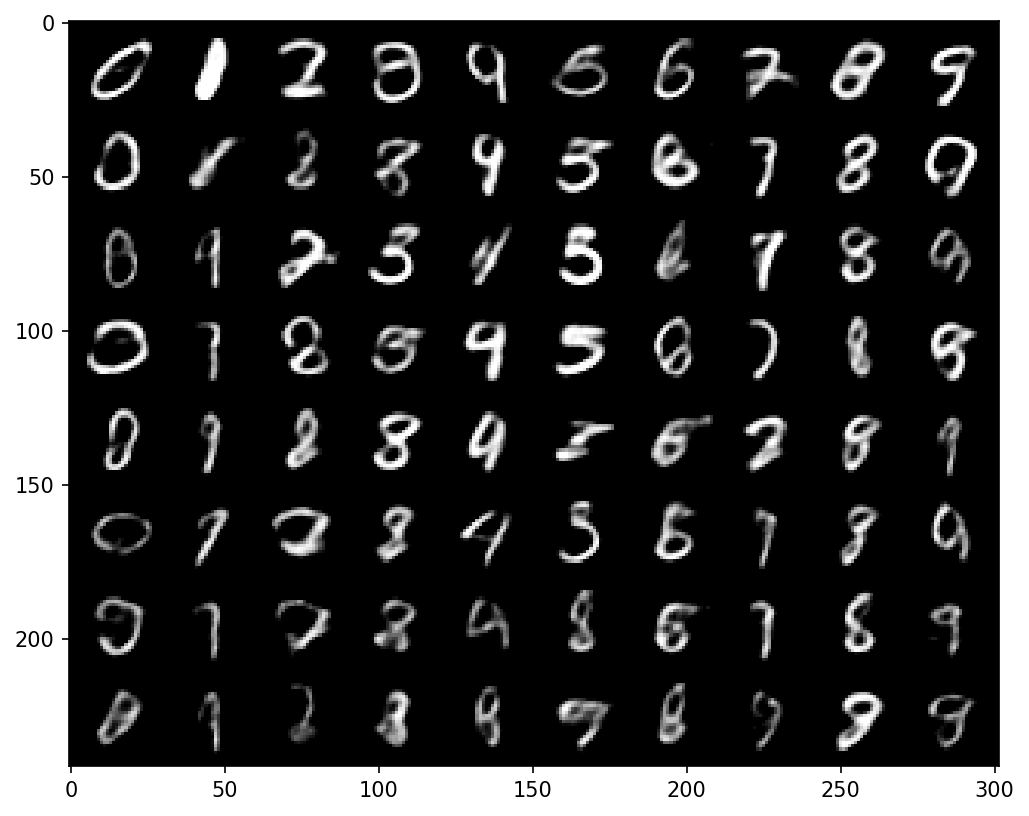

In [ ]:
show_stratified_samples(
    ambiguous_samples_convex_mixture,
    ambiguous_samples_convex_mixture_evaluation.pred_entropies,
    8,
    10,
    bin_range=[0.05, 1.2],
    predictions=ambiguous_samples_convex_mixture_evaluation.predictions,
    one_per_class=True,
)

The convex mixture samples look much better overall. However, we have to limit the entropy range to `[0.1, 1.4]` as there are not sufficiently many samples beyond that:

(array([8., 5., 2., 1., 2., 3., 1., 4., 0., 0.]),
 array([1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52, 1.54, 1.56, 1.58, 1.6 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

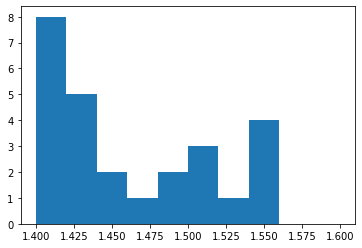

In [ ]:
plt.hist(
    ambiguous_samples_convex_mixture_evaluation.pred_entropies.numpy(),
    bins=10,
    range=[1.4, 1.6],
)

#### Label vs Entropy Distribution

We can look at the distribution of the labels (the most likely label). We see that the created samples are highly imbalanced.

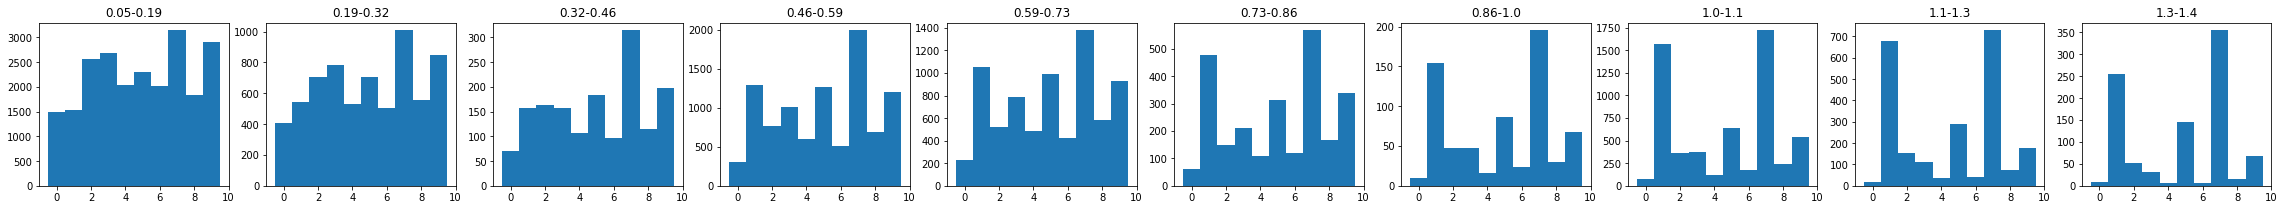

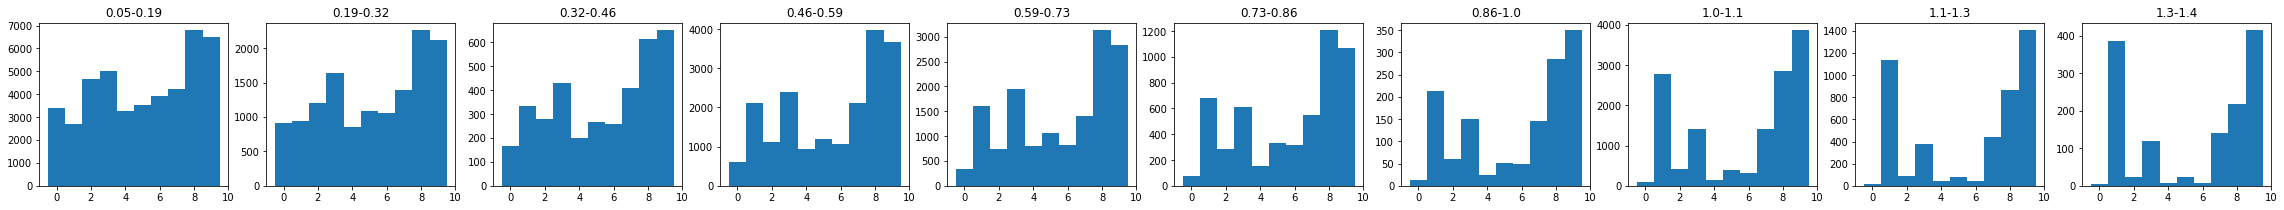

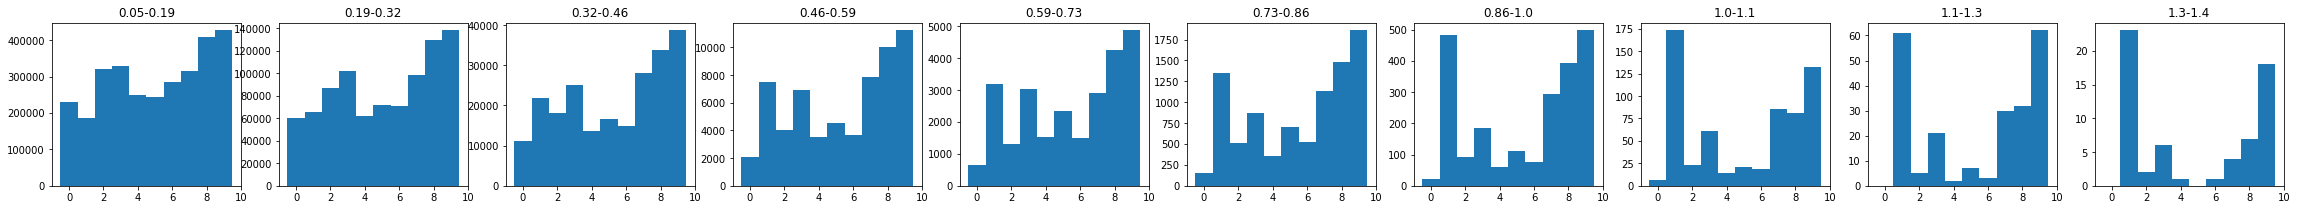

In [ ]:
def show_label_buckets(entropies, labels, num_bins, range=None):
    edges = np.histogram_bin_edges(entropies.numpy(), bins=num_bins, range=range)

    plt.figure(figsize=(num_bins * 4, 3))
    for i, (lower, upper) in enumerate(zip(edges[:-1], edges[1:])):
        plt.subplot(1, num_bins, i + 1)
        bucket_labels = labels[(lower <= entropies) & (entropies < upper)]
        # plt.yscale("log")
        plt.title(f"{lower:.2}-{upper:.2}")
        plt.hist(bucket_labels.numpy(), bins=10, range=[-0.5, 9.5])

    plt.show()


show_label_buckets(
    stratified_ambiguous_samples_random_latent_evaluation.pred_entropies,
    stratified_ambiguous_samples_random_latent_evaluation.single_labels,
    10,
    range=[0.05, 1.4],
)
show_label_buckets(
    stratified_ambiguous_samples_convex_mixture_evaluation.pred_entropies,
    stratified_ambiguous_samples_convex_mixture_evaluation.single_labels,
    10,
    range=[0.05, 1.4],
)
show_label_buckets(
    ambiguous_samples_convex_mixture_evaluation.pred_entropies,
    ambiguous_samples_convex_mixture_evaluation.single_labels,
    10,
    range=[0.05, 1.4],
)

### Class Probability vs Entropy
We can also look at the distribution of class probability vs entropy:

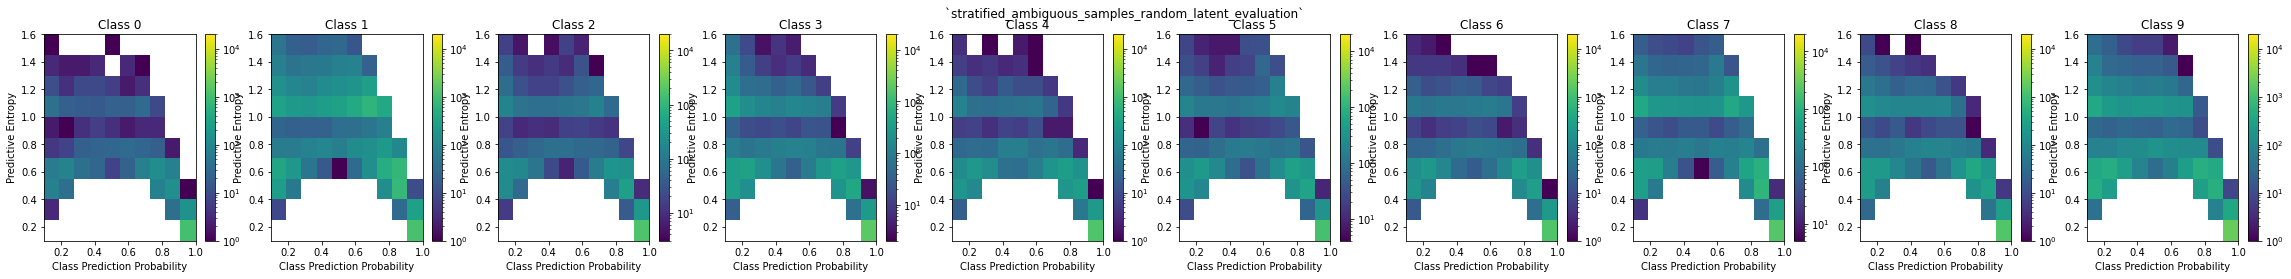

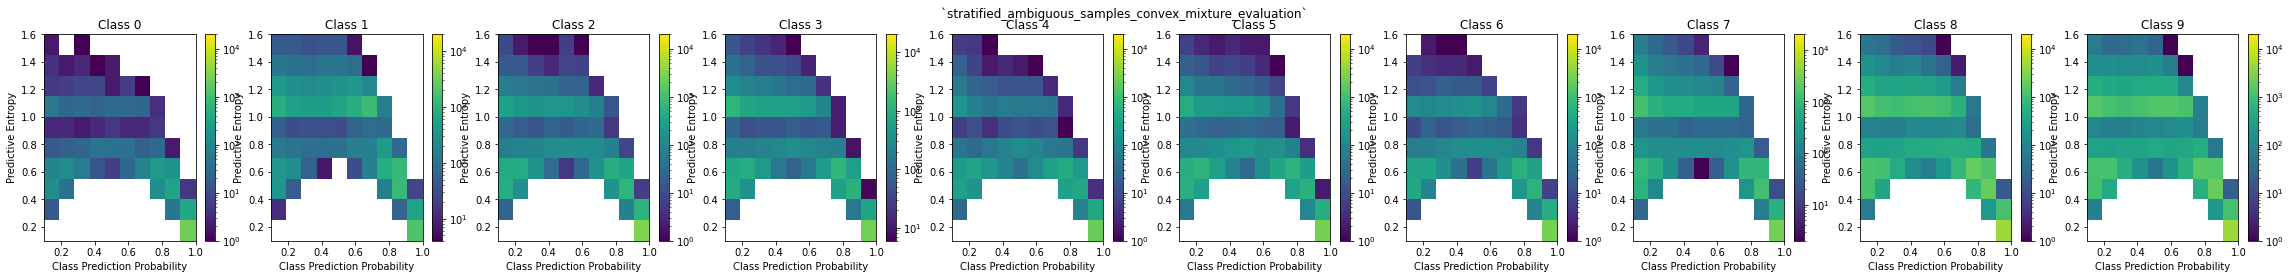

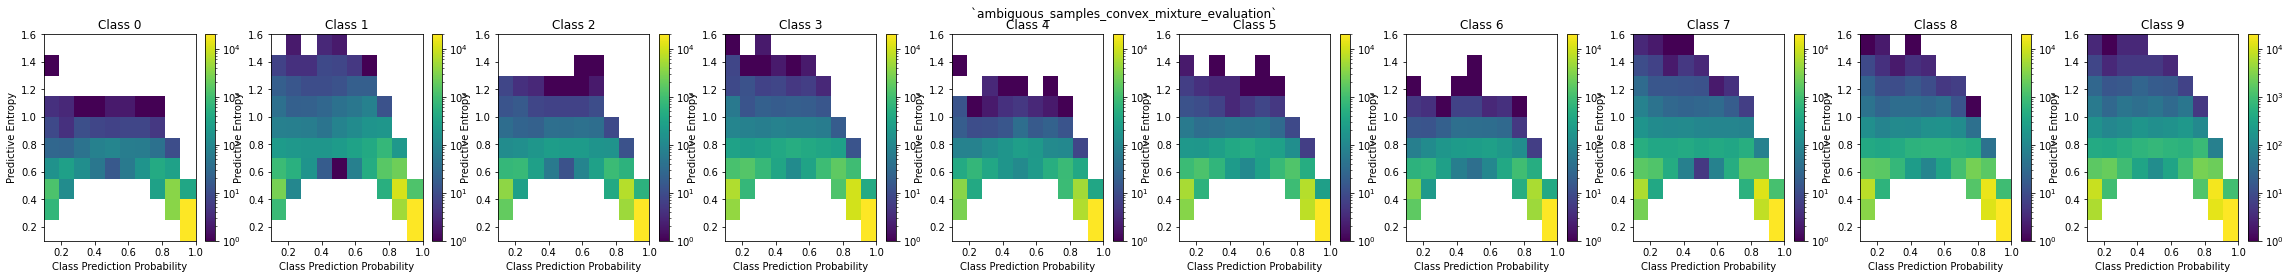

In [ ]:
import matplotlib as mpl


def show_probs_vs_entropy(evaluation: SampleEvaluation, num_bins, entropy_range=None):
    entropies = evaluation.pred_entropies
    predictions = evaluation.predictions

    plt.figure(figsize=(num_bins * 4, 3.8))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        h = plt.hist2d(
            predictions[:, i].numpy(),
            entropies.numpy(),
            bins=num_bins,
            norm=mpl.colors.LogNorm(vmax=2e4),
            range=[[0.1, 1], entropy_range],
        )
        plt.xlabel("Class Prediction Probability")
        plt.ylabel("Predictive Entropy")
        plt.title(f"Class {i}")
        ax = plt.gca()
        plt.colorbar(h[-1], use_gridspec=True, ax=ax)


show_probs_vs_entropy(stratified_ambiguous_samples_random_latent_evaluation, 10, entropy_range=[0.1, 1.6])
plt.suptitle("`stratified_ambiguous_samples_random_latent_evaluation`")
show_probs_vs_entropy(stratified_ambiguous_samples_convex_mixture_evaluation, 10, entropy_range=[0.1, 1.6])
plt.suptitle("`stratified_ambiguous_samples_convex_mixture_evaluation`")
show_probs_vs_entropy(ambiguous_samples_convex_mixture_evaluation, 10, entropy_range=[0.1, 1.6])
plt.suptitle("`ambiguous_samples_convex_mixture_evaluation`")
plt.show()

In [ ]:
# ambiguous_samples = stratified_ambiguous_samples_convex_mixture
# ambiguous_samples_evaluation = stratified_ambiguous_samples_convex_mixture_evaluation

ambiguous_samples = ambiguous_samples_convex_mixture
ambiguous_samples_evaluation = ambiguous_samples_convex_mixture_evaluation

## Creating Ambiguous-MNIST: Subsampling

We subsample the 4M samples while preserving the original histogram.

In [ ]:
def entropy(p):
    nats = -p * torch.log(p)
    nats[torch.isnan(nats)] = 0.0
    entropy = torch.sum(nats, dim=-1)
    return entropy

In [ ]:
def kl(p, q):
    items = -p * (torch.log(q) - torch.log(p))
    items[torch.isnan(items)] = 0.0
    kl = torch.sum(items, dim=-1)
    return kl

In [ ]:
def show_prob_buckets(entropies, predictions, num_bins, entropy_range=None):
    edges = np.histogram_bin_edges(entropies.numpy(), bins=num_bins, range=entropy_range)

    plt.figure(figsize=(num_bins * 4, 3))
    for i, (lower, upper) in enumerate(zip(edges[:-1], edges[1:])):
        plt.subplot(1, num_bins, i + 1)
        bucket_prob_distribution = predictions[(lower <= entropies) & (entropies < upper)].mean(dim=0)
        print(entropy(bucket_prob_distribution))
        # plt.yscale("log")
        plt.title(f"{lower:.2}-{upper:.2}")
        plt.ylim(0, 0.3)
        plt.bar(range(10), bucket_prob_distribution.numpy(), width=1)

    plt.show()

In [ ]:
import math

In [ ]:
def subsample_preserve_histogram(train_num_samples, test_num_samples, entropies):
    num_bins = 50
    hist, bin_edges = np.histogram(entropies, bins=50, range=[0.05, 1.6])

    subsampled_weights = hist ** 0.2 / len(entropies) ** 0.2
    subsampled_total = np.sum(subsampled_weights)
    subsampled_counts = subsampled_weights / subsampled_total * (train_num_samples + test_num_samples + num_bins)
    print(subsampled_counts)

    train_stratified_indices = []
    test_stratified_indices = []

    train_ratio = train_num_samples / (train_num_samples + test_num_samples)

    for lower_edge, upper_edge, target_count in zip(bin_edges[:-1], bin_edges[1:], subsampled_counts):
        mask = (lower_edge <= entropies) & (entropies < upper_edge)
        bucket_indices = torch.nonzero(mask, as_tuple=False)[:, 0]
        bucket_entropies = entropies[bucket_indices]

        sorted_entropies, original_indices = torch.sort(bucket_entropies)
        uniform_draws = torch.rand(math.ceil(target_count)) * (upper_edge - lower_edge) + lower_edge
        drawn_indices = torch.searchsorted(sorted_entropies, uniform_draws)

        stratified_bucket_indices = bucket_indices[original_indices[drawn_indices - 1]]
        train_bucket_size = math.ceil(len(stratified_bucket_indices) * train_ratio)
        train_stratified_indices.extend(stratified_bucket_indices[:train_bucket_size].tolist())
        test_stratified_indices.extend(stratified_bucket_indices[train_bucket_size:].tolist())

    return torch.as_tensor(train_stratified_indices), torch.as_tensor(test_stratified_indices)


@restore_or_create("subsample_indices_train_test.pt", recreate=True)
def get_subsample_train_test_indices():
    train_num_samples = int(60e3) // 10
    test_num_samples = int(60e3) // 10
    entropies = ambiguous_samples_evaluation.pred_entropies
    return subsample_preserve_histogram(train_num_samples, test_num_samples, entropies)


subsample_indices_train, subsample_indices_test = get_subsample_train_test_indices()

[706.29871749 654.96783187 622.44208438 593.27705191 562.41061374
 531.85808036 499.79787501 469.21870854 440.46216832 411.96691518
 386.40216757 362.78054718 341.35407513 322.45948332 304.21643396
 288.15820828 274.65056523 263.03897044 252.49643631 247.14638274
 246.4912762  235.77242529 218.50409662 203.98513382 192.05255056
 179.32146431 164.8447268  157.50244809 150.22266818 144.22455831
 131.86638274 119.44427082 118.63714098 112.05529191 109.47158813
 105.0684898  100.09800217  85.98578714  87.69545129  82.79218036
  76.34332452  73.23787625  72.07477925  69.49396188  66.46072417
  43.84772565  54.62246847  54.62246847  57.85742086   0.        ]


In [ ]:
# indices_train = entropy_balanced_indices[:6000]
# indices_test = entropy_balanced_indices[6000:8000]
indices_train = subsample_indices_train
indices_test = subsample_indices_test
len(indices_train), len(indices_test)

(6051, 6024)

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0, 6], [1], [2], [3, 8], [4], [5], [6], [7, 3], [8, 6], [9]]
[[0, 6], [1, 7], [2, 7], [3, 8], [4, 9], [5, 8], [6, 5], [7, 3], [8, 9], [9, 8]]
[[0, 6], [1, 7], [2, 3], [3, 5], [4, 9], [5], [6, 4], [7, 9], [8, 7], [9, 5]]


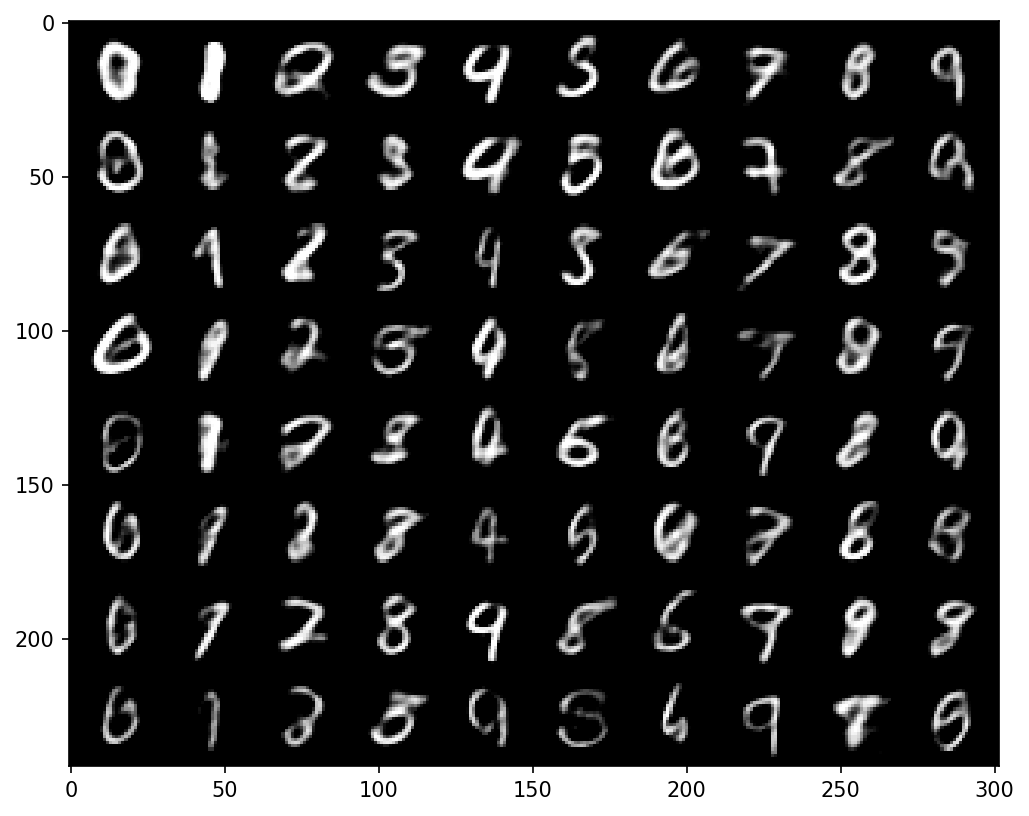

In [ ]:
show_stratified_samples(
    ambiguous_samples[indices_train],
    ambiguous_samples_evaluation.pred_entropies[indices_train],
    8,
    10,
    bin_range=[0.05, 0.8],
    predictions=ambiguous_samples_evaluation.predictions[indices_train],
    one_per_class=True,
)

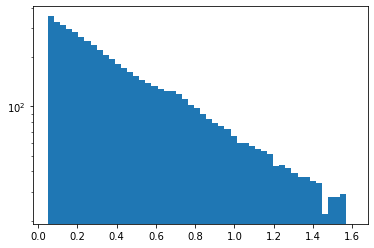

(array([353., 327., 311., 297., 281., 266., 250., 235., 220., 206., 193.,
        181., 171., 161., 152., 144., 137., 132., 126., 124., 123., 118.,
        109., 102.,  96.,  90.,  82.,  79.,  75.,  72.,  66.,  60.,  59.,
         56.,  55.,  53.,  50.,  43.,  44.,  41.,  38.,  37.,  36.,  35.,
         33.,  22.,  27.,  27.,  29.,   0.]),
 array([0.05 , 0.081, 0.112, 0.143, 0.174, 0.205, 0.236, 0.267, 0.298,
        0.329, 0.36 , 0.391, 0.422, 0.453, 0.484, 0.515, 0.546, 0.577,
        0.608, 0.639, 0.67 , 0.701, 0.732, 0.763, 0.794, 0.825, 0.856,
        0.887, 0.918, 0.949, 0.98 , 1.011, 1.042, 1.073, 1.104, 1.135,
        1.166, 1.197, 1.228, 1.259, 1.29 , 1.321, 1.352, 1.383, 1.414,
        1.445, 1.476, 1.507, 1.538, 1.569, 1.6  ], dtype=float32),
 <BarContainer object of 50 artists>)

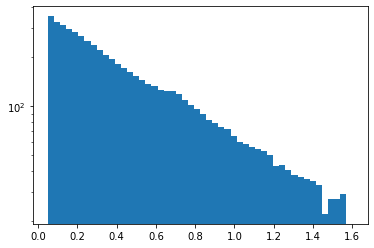

In [ ]:
plt.yscale("log")
plt.hist(
    ambiguous_samples_evaluation.pred_entropies[indices_train].numpy(),
    bins=50,
    range=[0.05, 1.6],
)
plt.show()
plt.yscale("log")
plt.hist(
    ambiguous_samples_evaluation.pred_entropies[indices_test].numpy(),
    bins=50,
    range=[0.05, 1.6],
)

In [ ]:
len(indices_train), len(indices_test)

(6051, 6024)

### Balanced Distribution per Entropy Bucket

(array([9.98572e+05, 7.01446e+05, 5.49851e+05, 4.46586e+05, 3.52206e+05,
        2.76367e+05, 2.11546e+05, 1.59399e+05, 1.19749e+05, 8.97830e+04,
        6.63780e+04, 4.97320e+04, 3.72810e+04, 2.85170e+04, 2.15700e+04,
        1.67970e+04, 1.30500e+04, 1.02340e+04, 8.26600e+03, 6.85000e+03,
        5.72600e+03, 5.12500e+03, 4.98100e+03, 4.64000e+03, 3.11000e+03,
        2.31000e+03, 1.74700e+03, 1.28300e+03, 9.37000e+02, 6.51000e+02,
        5.35000e+02, 4.31000e+02, 3.64000e+02, 2.34000e+02, 1.68000e+02,
        1.27000e+02, 1.22000e+02, 9.60000e+01, 7.70000e+01, 7.30000e+01,
        5.30000e+01, 2.80000e+01, 2.90000e+01, 2.40000e+01, 1.30000e+01,
        1.30000e+01, 8.00000e+00, 1.30000e+01, 1.00000e+01, 6.00000e+00]),
 array([0.05 , 0.078, 0.106, 0.134, 0.162, 0.19 , 0.218, 0.246, 0.274,
        0.302, 0.33 , 0.358, 0.386, 0.414, 0.442, 0.47 , 0.498, 0.526,
        0.554, 0.582, 0.61 , 0.638, 0.666, 0.694, 0.722, 0.75 , 0.778,
        0.806, 0.834, 0.862, 0.89 , 0.918, 0.946, 0.974

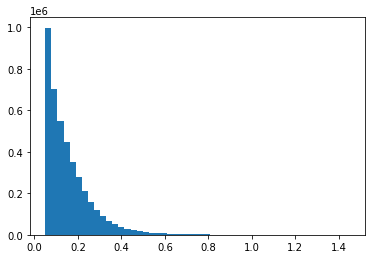

In [ ]:
plt.hist(
    ambiguous_samples_evaluation.pred_entropies.numpy(),
    bins=50,
    range=[0.05, 1.45],
)

tensor(2.2605)
tensor(2.2152)
tensor(2.1592)
tensor(1.9849)
tensor(1.8502)


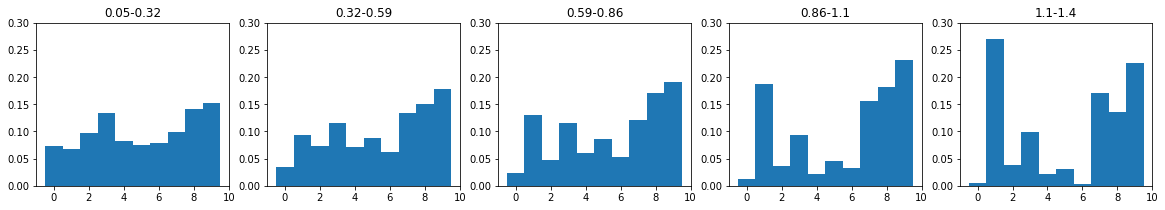

In [ ]:
show_prob_buckets(
    ambiguous_samples_evaluation.pred_entropies[indices_train],
    ambiguous_samples_evaluation.predictions[indices_train],
    5,
    entropy_range=[0.05, 1.40],
)

#### Original Stratified Distribution

tensor(2.2702)
tensor(2.2226)
tensor(2.1699)
tensor(2.0320)
tensor(1.8986)


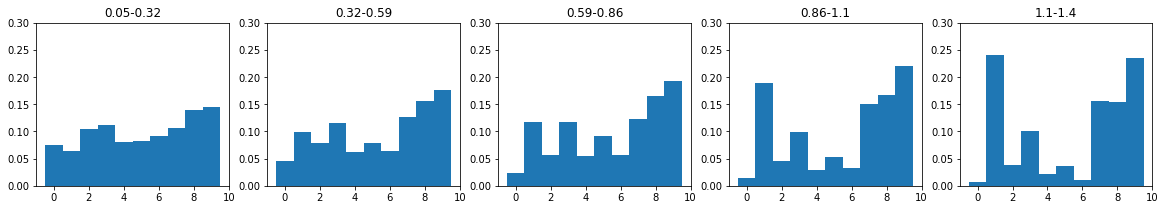

In [ ]:
show_prob_buckets(
    ambiguous_samples_evaluation.pred_entropies,
    ambiguous_samples_evaluation.predictions,
    5,
    entropy_range=[0.05, 1.40],
)

### Visualize Balanced & Stratified Samples

[[0], [4], [3], [1]]
[[0], [3], [3], [9]]
[[9], [2], [1], [3]]
[[9], [4], [7], [7]]
[[9], [8], [9], [6]]
[[9, 7], [7], [2, 8], [5]]
[[5, 6], [7, 9], [5, 8], [6, 5]]
[[8, 3], [6, 8], [3, 8], [1, 4]]
[[8, 1], [7, 9], [9, 8], [8, 2]]
[[7, 9], [9, 8], [5, 8], [8, 1]]


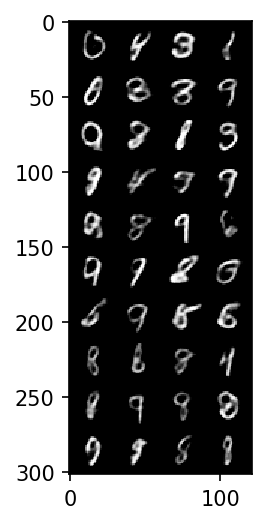

In [ ]:
show_stratified_samples(
    ambiguous_samples[indices_train],
    ambiguous_samples_evaluation.pred_entropies[indices_train],
    10,
    4,
    bin_range=[0.05, 1.0],
    predictions=ambiguous_samples_evaluation.predictions[indices_train],
)
plt.show()

### Generating Labels for Ambiguous-MNIST

We will draw 10 labels for each sample. First we will shuffle the balanced indices though.

In [ ]:
shuffled_balanced_amnist_indices_train = indices_train[torch.randperm(len(indices_train))][:6000]
shuffled_balanced_amnist_indices_test = indices_test[torch.randperm(len(indices_test))][:6000]

shuffled_balanced_amnist_indices = torch.cat(
    [shuffled_balanced_amnist_indices_train, shuffled_balanced_amnist_indices_test]
)
len(shuffled_balanced_amnist_indices)

12000

In [ ]:
amnist_predictions = ambiguous_samples_evaluation.predictions[shuffled_balanced_amnist_indices]
len(amnist_predictions)

12000

In [ ]:
def draw_labels(predictions, num_labels):
    drawn_labels = torch.multinomial(predictions, num_samples=num_labels, replacement=True)
    return drawn_labels

In [ ]:
@restore_or_create("internal_amnist_labels.pt", recreate=True)
def create_amnist_labels():
    amnist_labels = draw_labels(amnist_predictions, 10)
    return amnist_labels


amnist_labels = create_amnist_labels()

In [ ]:
amnist_samples = ambiguous_samples[shuffled_balanced_amnist_indices]
amnist_unnormalized_samples = adjusted_post_process_vae_output(amnist_samples)

In [ ]:
torch.save(amnist_predictions, "amnist_predictions.pt")
torch.save(amnist_labels, "amnist_labels.pt")
torch.save(amnist_samples, "amnist_raw_samples.pt")
torch.save(amnist_unnormalized_samples, "amnist_samples.pt")

## Evaluating DirtyMNIST and AMNIST

### Setup Datasets and DataLoaders

In [ ]:
amnist_samples = torch.load("amnist_samples.pt").expand(-1, 10, 28, 28).reshape(-1, 1, 28, 28)
amnist_labels = torch.load("amnist_labels.pt").reshape(-1)
amnist_samples.shape, amnist_labels.shape

(torch.Size([120000, 1, 28, 28]), torch.Size([120000]))

In [ ]:
amnist_normalized_samples = normalize_mnist(amnist_samples)

In [ ]:
amnist_train_dataset = torch.utils.data.TensorDataset(amnist_normalized_samples[:-60000], amnist_labels[:-60000])
amnist_test_dataset = torch.utils.data.TensorDataset(amnist_normalized_samples[-60000:], amnist_labels[-60000:])

In [ ]:
# MNIST is weird and use numpy labels, which messes up the DataLoaders
amnist_train_dataset.tensors = (
    amnist_train_dataset.tensors[0],
    amnist_train_dataset.tensors[1].numpy(),
)
amnist_test_dataset.tensors = (
    amnist_test_dataset.tensors[0],
    amnist_test_dataset.tensors[1].numpy(),
)

In [ ]:
amnist_train_loader = torch.utils.data.DataLoader(
    dataset=amnist_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=torch.cuda.is_available(),
)
amnist_test_loader = torch.utils.data.DataLoader(
    dataset=amnist_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=torch.cuda.is_available(),
)

In [ ]:
dmnist_train_dataset = torch.utils.data.ConcatDataset([mnist_train_dataset, amnist_train_dataset])
dmnist_test_dataset = torch.utils.data.ConcatDataset([mnist_test_dataset, amnist_test_dataset])

In [ ]:
dmnist_train_loader = torch.utils.data.DataLoader(
    dataset=dmnist_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=torch.cuda.is_available(),
)
dmnist_test_loader = torch.utils.data.DataLoader(
    dataset=dmnist_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=torch.cuda.is_available(),
)

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.1307,),
            (0.3081,),
        ),
    ]
)


fmnist_train_dataset = datasets.FashionMNIST(
    root="./fmnist_data/",
    train=True,
    download=True,
    transform=transform,
)

fmnist_test_dataset = datasets.FashionMNIST(
    root="./fmnist_data/",
    train=False,
    download=True,
    transform=transform,
)

fmnist_train_loader = torch.utils.data.DataLoader(
    fmnist_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=torch.cuda.is_available(),
)

fmnist_test_loader = torch.utils.data.DataLoader(
    fmnist_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=torch.cuda.is_available(),
)

### Training a LeNet Ensemble on DMNIST

In [ ]:
dmnist_lenets = []
num_ensemble_components = 5

for i in tqdm(range(num_ensemble_components)):

    @restore_or_create(f"dmnist_lenet_model_{i}.model", recreate=True)
    def train_lenet_model():
        lenet = LeNet(num_classes=10).cuda()
        optimizer = optim.Adam(lenet.parameters())

        best_loss = None
        best_epoch = None
        for epoch in tqdm(range(5)):  # lenet seems to converge after about 10 epochs anyways..
            lenet_train(epoch, dmnist_train_loader, optimizer, lenet)
            test_loss = lenet_test(mnist_test_loader, lenet)
            if not best_loss or best_loss > test_loss:
                torch.save(lenet.state_dict(), "./tmp_lenet_best.model")
                best_loss = test_loss
                best_epoch = epoch
                print("New best model", best_epoch, " with ", best_loss)

        print("Best epoch", best_epoch)

        lenet.load_state_dict(torch.load("./tmp_lenet_best.model"))
        return lenet

    dmnist_lenets.append(train_lenet_model())

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 0 [0/120000 (0%)]	Loss: 0.017995
Train Epoch: 0 [12800/120000 (11%)]	Loss: 0.005736
Train Epoch: 0 [25600/120000 (21%)]	Loss: 0.003308
Train Epoch: 0 [38400/120000 (32%)]	Loss: 0.003268
Train Epoch: 0 [51200/120000 (43%)]	Loss: 0.003110
Train Epoch: 0 [64000/120000 (53%)]	Loss: 0.003038
Train Epoch: 0 [76800/120000 (64%)]	Loss: 0.002704
Train Epoch: 0 [89600/120000 (75%)]	Loss: 0.002006
Train Epoch: 0 [102400/120000 (85%)]	Loss: 0.002995
Train Epoch: 0 [115200/120000 (96%)]	Loss: 0.003755
====> Epoch: 0 Average loss: 0.0040
====> Test set loss: 0.0006
New best model 0  with  0.0005556637394998689
Train Epoch: 1 [0/120000 (0%)]	Loss: 0.002971
Train Epoch: 1 [12800/120000 (11%)]	Loss: 0.002680
Train Epoch: 1 [25600/120000 (21%)]	Loss: 0.002379
Train Epoch: 1 [38400/120000 (32%)]	Loss: 0.003004
Train Epoch: 1 [51200/120000 (43%)]	Loss: 0.002910
Train Epoch: 1 [64000/120000 (53%)]	Loss: 0.001870
Train Epoch: 1 [76800/120000 (64%)]	Loss: 0.001991
Train Epoch: 1 [89600/120000 (7

  0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 0 [0/120000 (0%)]	Loss: 0.018011
Train Epoch: 0 [12800/120000 (11%)]	Loss: 0.004964
Train Epoch: 0 [25600/120000 (21%)]	Loss: 0.005049
Train Epoch: 0 [38400/120000 (32%)]	Loss: 0.004067
Train Epoch: 0 [51200/120000 (43%)]	Loss: 0.002983
Train Epoch: 0 [64000/120000 (53%)]	Loss: 0.003023
Train Epoch: 0 [76800/120000 (64%)]	Loss: 0.002248
Train Epoch: 0 [89600/120000 (75%)]	Loss: 0.002063
Train Epoch: 0 [102400/120000 (85%)]	Loss: 0.001877
Train Epoch: 0 [115200/120000 (96%)]	Loss: 0.001769
====> Epoch: 0 Average loss: 0.0039
====> Test set loss: 0.0005
New best model 0  with  0.000494871441333089
Train Epoch: 1 [0/120000 (0%)]	Loss: 0.002341
Train Epoch: 1 [12800/120000 (11%)]	Loss: 0.002551
Train Epoch: 1 [25600/120000 (21%)]	Loss: 0.002591
Train Epoch: 1 [38400/120000 (32%)]	Loss: 0.002494
Train Epoch: 1 [51200/120000 (43%)]	Loss: 0.003826
Train Epoch: 1 [64000/120000 (53%)]	Loss: 0.002245
Train Epoch: 1 [76800/120000 (64%)]	Loss: 0.003237
Train Epoch: 1 [89600/120000 (75

  0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 0 [0/120000 (0%)]	Loss: 0.018130
Train Epoch: 0 [12800/120000 (11%)]	Loss: 0.005003
Train Epoch: 0 [25600/120000 (21%)]	Loss: 0.005570
Train Epoch: 0 [38400/120000 (32%)]	Loss: 0.003198
Train Epoch: 0 [51200/120000 (43%)]	Loss: 0.003475
Train Epoch: 0 [64000/120000 (53%)]	Loss: 0.004082
Train Epoch: 0 [76800/120000 (64%)]	Loss: 0.002947
Train Epoch: 0 [89600/120000 (75%)]	Loss: 0.002648
Train Epoch: 0 [102400/120000 (85%)]	Loss: 0.002472
Train Epoch: 0 [115200/120000 (96%)]	Loss: 0.003643
====> Epoch: 0 Average loss: 0.0040
====> Test set loss: 0.0005
New best model 0  with  0.0004952335684502031
Train Epoch: 1 [0/120000 (0%)]	Loss: 0.002366
Train Epoch: 1 [12800/120000 (11%)]	Loss: 0.003144
Train Epoch: 1 [25600/120000 (21%)]	Loss: 0.003569
Train Epoch: 1 [38400/120000 (32%)]	Loss: 0.002573
Train Epoch: 1 [51200/120000 (43%)]	Loss: 0.003850
Train Epoch: 1 [64000/120000 (53%)]	Loss: 0.003415
Train Epoch: 1 [76800/120000 (64%)]	Loss: 0.002119
Train Epoch: 1 [89600/120000 (7

  0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 0 [0/120000 (0%)]	Loss: 0.018008
Train Epoch: 0 [12800/120000 (11%)]	Loss: 0.006362
Train Epoch: 0 [25600/120000 (21%)]	Loss: 0.004746
Train Epoch: 0 [38400/120000 (32%)]	Loss: 0.003279
Train Epoch: 0 [51200/120000 (43%)]	Loss: 0.004015
Train Epoch: 0 [64000/120000 (53%)]	Loss: 0.004320
Train Epoch: 0 [76800/120000 (64%)]	Loss: 0.002251
Train Epoch: 0 [89600/120000 (75%)]	Loss: 0.002484
Train Epoch: 0 [102400/120000 (85%)]	Loss: 0.004053
Train Epoch: 0 [115200/120000 (96%)]	Loss: 0.002170
====> Epoch: 0 Average loss: 0.0041
====> Test set loss: 0.0006
New best model 0  with  0.0006225511143915356
Train Epoch: 1 [0/120000 (0%)]	Loss: 0.002408
Train Epoch: 1 [12800/120000 (11%)]	Loss: 0.003077
Train Epoch: 1 [25600/120000 (21%)]	Loss: 0.002279
Train Epoch: 1 [38400/120000 (32%)]	Loss: 0.002024
Train Epoch: 1 [51200/120000 (43%)]	Loss: 0.003460
Train Epoch: 1 [64000/120000 (53%)]	Loss: 0.001220
Train Epoch: 1 [76800/120000 (64%)]	Loss: 0.002812
Train Epoch: 1 [89600/120000 (7

  0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 0 [0/120000 (0%)]	Loss: 0.018015
Train Epoch: 0 [12800/120000 (11%)]	Loss: 0.005529
Train Epoch: 0 [25600/120000 (21%)]	Loss: 0.003745
Train Epoch: 0 [38400/120000 (32%)]	Loss: 0.004135
Train Epoch: 0 [51200/120000 (43%)]	Loss: 0.002949
Train Epoch: 0 [64000/120000 (53%)]	Loss: 0.003931
Train Epoch: 0 [76800/120000 (64%)]	Loss: 0.002260
Train Epoch: 0 [89600/120000 (75%)]	Loss: 0.002750
Train Epoch: 0 [102400/120000 (85%)]	Loss: 0.002234
Train Epoch: 0 [115200/120000 (96%)]	Loss: 0.002732
====> Epoch: 0 Average loss: 0.0039
====> Test set loss: 0.0005
New best model 0  with  0.0005182982818398159
Train Epoch: 1 [0/120000 (0%)]	Loss: 0.002806
Train Epoch: 1 [12800/120000 (11%)]	Loss: 0.002152
Train Epoch: 1 [25600/120000 (21%)]	Loss: 0.002929
Train Epoch: 1 [38400/120000 (32%)]	Loss: 0.002460
Train Epoch: 1 [51200/120000 (43%)]	Loss: 0.003717
Train Epoch: 1 [64000/120000 (53%)]	Loss: 0.002086
Train Epoch: 1 [76800/120000 (64%)]	Loss: 0.003809
Train Epoch: 1 [89600/120000 (7

### Evaluating the DMNIST LeNet Ensemble

In [ ]:
@dataclass
class Evaluation:
    predictions: torch.Tensor
    entropies: torch.Tensor
    labels: torch.Tensor

In [ ]:
@torch.no_grad()
def evaluate(test_loader, lenets):
    for lenet in lenets:
        lenet.eval()

    labels = []
    predictions = []
    with torch.no_grad():
        for data, label in tqdm(test_loader):
            data = data.cuda()
            label = label.cuda()

            batch_outputs = [lenet(data.cuda()) for lenet in lenets]
            batch_outputs = torch.stack(batch_outputs)
            batch_predictions = F.softmax(batch_outputs.mean(dim=0), dim=-1)
            predictions.append(batch_predictions)
            labels.append(label)

    labels = torch.cat(labels).cpu()
    predictions = torch.cat(predictions).cpu()
    entropies = entropy(predictions).cpu()
    return Evaluation(predictions, entropies, labels)

In [ ]:
dmnist_test_evaluation = evaluate(dmnist_test_loader, dmnist_lenets)
amnist_test_evaluation = evaluate(amnist_test_loader, dmnist_lenets)
mnist_test_evaluation = evaluate(mnist_test_loader, dmnist_lenets)
fmnist_test_evaluation = evaluate(fmnist_test_loader, dmnist_lenets)

  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
print(
    "MNIST accuracy",
    (mnist_test_evaluation.predictions.argmax(dim=-1) == mnist_test_evaluation.labels).sum().item()
    / len(mnist_test_evaluation.labels)
    * 100,
)

MNIST accuracy 99.08


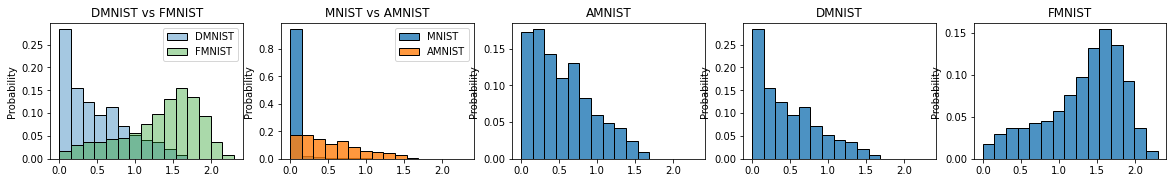

In [ ]:
import seaborn as sns


def plot_entropies(evaluation: Evaluation, **kwargs):
    # plt.ylim(0, 0.15)
    sns.histplot(evaluation.entropies.numpy(), stat="probability", binrange=[0.0, np.log(10)], bins=15, **kwargs)


plt.figure(figsize=(5 * 4, 4 / 1.6))
plt.subplot(1, 5, 1)
plot_entropies(
    dmnist_test_evaluation,
    alpha=0.4,
    color=sns.color_palette()[0],
    label="DMNIST",
)
plot_entropies(
    fmnist_test_evaluation,
    alpha=0.4,
    color=sns.color_palette()[2],
    label="FMNIST",
)
plt.legend()
plt.title("DMNIST vs FMNIST")
plt.subplot(1, 5, 2)
plot_entropies(
    mnist_test_evaluation,
    alpha=0.8,
    color=sns.color_palette()[0],
    label="MNIST",
)
plot_entropies(
    amnist_test_evaluation,
    alpha=0.8,
    color=sns.color_palette()[1],
    label="AMNIST",
)
plt.title("MNIST vs AMNIST")
plt.legend()
plt.subplot(1, 5, 3)
plot_entropies(
    amnist_test_evaluation,
    alpha=0.8,
    color=sns.color_palette()[0],
    label="AMNIST",
)
plt.title("AMNIST")
plt.subplot(1, 5, 4)
plot_entropies(
    dmnist_test_evaluation,
    alpha=0.8,
    color=sns.color_palette()[0],
    label="DMNIST",
)
plt.title("DMNIST")
plt.subplot(1, 5, 5)
plot_entropies(
    fmnist_test_evaluation,
    alpha=0.8,
    color=sns.color_palette()[0],
    label="FMNIST",
)
plt.title("FMNIST")

plt.show()

This shows that training on DirtyMNIST (MNIST + Ambiguous-MNIST) will lead to predictions that correctly span a wide range of aleatoric uncertainty, causing overlaps with OOD data which is also assigned high entropy. We note that there is high overlap, even though we use a LeNet ensemble.